<a href="https://colab.research.google.com/github/hooman007/cs533-hw1/blob/master/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CPSC 533R Visual AI - Assignment 1

A few notes about our process:

*   To correctly select the second index in `__getitem__`, we initialized our FashionMNIST dataset wrapper with correctly mutualy exclusive indices for train and validation subsets from the 60k FashionMNSIT train dataset. This is because using torch.utils.data.subset was not enough in limiting the accessible data indices in getitem, thus not guaranteeing mutual exclusiveness between train and valid subsets. (Please refer to function `split_data(split, split_cfg)` )
*   We decided to balance the batch making process by trying to create equal number of matching and non-matdching image pairs in each batch. To do so, we coded `__getitem__` to generate the pair based on a coin-toss, thus almost balancing the generated pairs. This needed initializing a dictionary mapping each MNIST class to the data indices. (please refer to `index_labels(self)`)
*   We also included the running average for training and validation losses
*   For fully end-to-end training, we decided to use use a siamese network made from ResNet18, but instead of using its last FC section, we replaced it with 2 FC layers to use more spatial features from our pair images extracted by ResNet. 







In [1]:
# %pdb
# import native modules
import os
import cv2
from os.path import exists
import numpy as np
from tqdm import tqdm

# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, Subset, DataLoader

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 20})
from collections import namedtuple
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

In [2]:
print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

if not exists('./data'):
  os.makedirs('./data')

1.6.0


In [3]:
def seed_everything(seed=0, harsh=False):
    """
    Seeds all important random functions
    Args:
        seed (int, optional): seed value. Defaults to 0.
        harsh (bool, optional): torch backend deterministic. Defaults to False.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed_all(seed)

    if harsh:
        torch.backends.cudnn.enabled = False
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything()

In [4]:
def dict_to_device(d_ten: dict, device):
    """
    Sets a dictionary to device
    Args:
        d_ten (dict): dictionary of tensors
        device (str): torch device
    Returns:
        dict: dictionary on device
    """
    for key, tensor in d_ten.items():
        if type(tensor) is torch.Tensor:
            d_ten[key] = d_ten[key].to(device)

    return d_ten

## Dataset & Dataloader

In [5]:
class MyDataset(Dataset):
    def __init__(self, split, data_root):
        self.download_data(split, data_root)
        
    def gray_to_color(self, x):
        return x.repeat(3, 1, 1)
        
    def download_data(self, split, root):
        self.data = torchvision.datasets.FashionMNIST(
            root = root,
            train = split == 'train',
            download = True,
            transform = transforms.Compose([
                transforms.ToTensor(),
                self.gray_to_color,
            ])
        )
    
    def __len__(self):
        return self.data.__len__()
    
    def __getitem__(self, index):
        img, target = self.data.__getitem__(index)
        return {'img': img,
                'class': target}

In [6]:
class PairwiseDataset(Dataset):
    def __init__(self, split, data_root, split_cfg = None): # TODO CHECK
        self.split = split
        self.download_data(split, data_root)
        self.split_indices = self.split_data(split, split_cfg)
        self.index_labels()

    def gray_to_color(self, x):
        return x.repeat(3, 1, 1)
        
    def download_data(self, split, root):
        self.data = torchvision.datasets.FashionMNIST(
            root = root,
            train = split == 'train' or split == 'valid', 
            download = True,
            transform = transforms.Compose([
                transforms.ToTensor(),
                self.gray_to_color,
            ])
        )

    def split_data(self, split, split_cfg):
        """
        splits the indices of dataset into train and validation subsets
        Args:
            split (str): mode of the split, can be train/valid
            split_cfg (dict): dictionary containing the random seed and test size
        Returns:
            list: list of indices for the selected split mode
        """
        if split == 'test':
            return None
        else:
            if split_cfg is None:
                raise ("split mode is train or valid, requires a seed for split")
            else:
                split_indices = train_test_split(list(range(len(self.data))),
                                                    test_size=split_cfg['test_size'], 
                                                    random_state = split_cfg['split_seed'])
                if split == 'train':
                    return split_indices[0]
                elif split == 'valid':
                    return split_indices[1]
                else:
                    raise ("Invalid split mode selected")

    def index_labels(self):
        """
        Splits the indices of dataset into a dictionary based on label classes.
        Used for balancing the classes in batch making process

        Returns:
            dict: dictionary on indicies for each label class
        """
        targets = self.data.targets.numpy()
        labels = np.unique(targets)
        label_indices = dict()

        for label in labels:
            label_indices[label] = np.where(targets == label)[0]
            #  finding the intersection of our data subset with indices of each class
            #  to avoid train-validation data overlap
            if self.split_indices is not None :
                label_indices_set1 = set(label_indices[label])
                label_indices[label]  = np.asarray(list(label_indices_set1.intersection(self.split_indices)))

        self.label_indices = label_indices
        
    def __len__(self):
        if self.split.__eq__('test'):
            return self.data.__len__()
        return len(self.split_indices)
    
    def __getitem__(self, index):
        img1, primary = self.data.__getitem__(index)
        ## Sample a matching pair based on a coin-toss -> roughly balanced dataset
        pick_same = bool(np.random.randint(0, 2))
        if pick_same:
            idx2 = np.random.choice(self.label_indices[primary])
            target = 1.0
        else:
            candidates = list(range(10))
            candidates.remove(primary)
            secondary = np.random.choice(candidates)
            idx2 = np.random.choice(self.label_indices[secondary])
            target = 0.0
        
        img2 = self.data.__getitem__(idx2)[0]
        
        return {
                'img1': img1,
                'img2': img2,
                'class': torch.FloatTensor([target])
               }

In [7]:
cfg = {
    'exp_name': 'sgd',
    'batch_size': 64,
    'opt': 'torch.optim.SGD',
    'opt_args': {
        'lr': 0.01
    },
    'epochs': 10,
    'split_cfg':{
        'split_seed': 42,
        'test_size': 0.3,
    }
}

In [8]:
# test_dataset = MyDataset(split='test', data_root='./data/DatasetFashionMNIST')
test_dataset = PairwiseDataset(split='test', data_root='./data/DatasetFashionMNIST')
test_loader = DataLoader(test_dataset, batch_size=cfg['batch_size'], num_workers=0, shuffle=False, pin_memory=True)
print(len(test_dataset))

10000


### Split into train and val

In [9]:
train_dataset = PairwiseDataset(split='train', data_root='./data/DatasetFashionMNIST', split_cfg=cfg['split_cfg'])
val_dataset = PairwiseDataset(split='valid', data_root='./data/DatasetFashionMNIST', split_cfg=cfg['split_cfg'])

In [10]:
train_loader = DataLoader(train_dataset, batch_size = cfg['batch_size'], num_workers=0, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size = cfg['batch_size'], num_workers=0, shuffle=False, pin_memory=True)

In [11]:
len(train_loader), len(val_loader)

(657, 282)

In [12]:
train_dataset.__len__(), val_dataset.__len__(), test_dataset.__len__()

(42000, 18000, 10000)

## Network

In [13]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.build_modules()
        
    def build_modules(self):
        self.network = torchvision.models.resnet18(num_classes=10)
        
    def forward(self, input_dict):
        pred = self.network(input_dict['img'])
        return {'class': pred}

In [14]:
class Siamese(nn.Module):
    def __init__(self):
        super(Siamese, self).__init__()
        self.build_modules()
        
    def build_modules(self):
        resnet = torchvision.models.resnet18(num_classes=1)
        self.heads = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Sequential(
                    nn.Linear(in_features=1024, out_features=512, bias=True),
                    nn.ReLU(),
                    nn.Linear(in_features=512, out_features=1, bias=True)
        )
        
    def forward(self, input_dict):
        feature1 = self.heads(input_dict['img1'])
        feature2 = self.heads(input_dict['img2'])
        merged = torch.cat((feature1, feature2), dim=1)
        merged = merged.view(merged.shape[0], -1)
        pred = torch.sigmoid(self.fc(merged))
        
        return {'class': pred}

## Training

In [15]:
def epoch(mode, epoch_id=0):
    losses = []
    pred = []
    gt = []
    loader = eval("{}_loader".format(mode))
    data_iter = iter(loader)
    
    if mode.__eq__('train'):
        model.network.train()
    else:
        model.network.eval()
        
    iterator = tqdm(range(len(loader)), dynamic_ncols=True)
    for i in iterator:
        batch = dict_to_device(next(data_iter), device)
        if mode.__eq__('train'):
            preds = model.network(batch)
        else:
            with torch.no_grad():
                preds = model.network(batch)
        pred.append(preds['class'])
        gt.append(batch['class'])

        loss = model.criterion(preds['class'], batch['class'])
        
        if mode.__eq__('train'):
            model.optimizer.zero_grad()
            loss.backward()
            model.optimizer.step()
        losses.append(loss.item())
        
        iterator.set_description("Epoch {} | {} | loss: {:.4f}".format(epoch_id, mode, loss.item()))

    return losses, pred, gt

In [16]:
def accuracy(gt, pred, threshold=None):
    if threshold is not None:
        gt = torch.cat(gt).reshape(-1,).detach().cpu()
        pred = torch.cat(pred).reshape(-1,).detach().cpu()
        pred[torch.where(pred > threshold)[0]] = torch.tensor(1.)
        pred[torch.where(pred < threshold)[0]] = torch.tensor(0.)
        matches = (pred == gt).float().numpy().sum()
        return matches / gt.shape[0]
        
    acc = (torch.cat(gt) == torch.cat(pred)).float().detach().cpu().numpy()
    return acc.sum()/len(acc)

In [17]:
def train():
    epochs = cfg['epochs']
    train_acc = []
    val_acc = []
    train_losses = []
    val_losses = []
    
    for i in range(epochs):
        for mode in ['train', 'val']:
            losses, pred, gt = epoch(mode, i)
            
            eval("{}_losses".format(mode)).extend(losses)
            
            eval("{}_acc".format(mode)).append(accuracy(gt, pred, threshold=0.5))
    
    return train_acc, val_acc, train_losses, val_losses

## Initialize model

In [18]:
my_network = Siamese().to(device)
opt = eval(cfg['opt'])
optimizer = opt(my_network.parameters(), lr=cfg['opt_args']['lr'])
criterion = nn.BCELoss()
model_tuple = namedtuple("model", ["network", "optimizer", "criterion"])
model = model_tuple(my_network, optimizer, criterion)

## Train

In [19]:
train_acc, val_acc, train_losses, val_losses = train()
print("===================================================")
print("TRAINING COMPLETE")

Epoch 0 | train | loss: 0.2328: 100%|██████████| 657/657 [01:11<00:00,  9.24it/s]
Epoch 0 | val | loss: 0.3213: 100%|██████████| 282/282 [00:10<00:00, 26.66it/s]
Epoch 1 | train | loss: 0.5250: 100%|██████████| 657/657 [01:20<00:00,  8.20it/s]
Epoch 1 | val | loss: 0.2349: 100%|██████████| 282/282 [00:11<00:00, 25.22it/s]
Epoch 2 | train | loss: 0.2977: 100%|██████████| 657/657 [01:20<00:00,  8.15it/s]
Epoch 2 | val | loss: 0.6105: 100%|██████████| 282/282 [00:11<00:00, 24.85it/s]
Epoch 3 | train | loss: 0.2837: 100%|██████████| 657/657 [01:21<00:00,  8.10it/s]
Epoch 3 | val | loss: 0.2461: 100%|██████████| 282/282 [00:11<00:00, 24.77it/s]
Epoch 4 | train | loss: 0.1172: 100%|██████████| 657/657 [01:20<00:00,  8.12it/s]
Epoch 4 | val | loss: 0.3062: 100%|██████████| 282/282 [00:11<00:00, 25.27it/s]
Epoch 5 | train | loss: 0.1106: 100%|██████████| 657/657 [01:19<00:00,  8.29it/s]
Epoch 5 | val | loss: 0.0752: 100%|██████████| 282/282 [00:11<00:00, 25.39it/s]
Epoch 6 | train | loss: 0.20

TRAINING COMPLETE


## Visualize losses per iteration

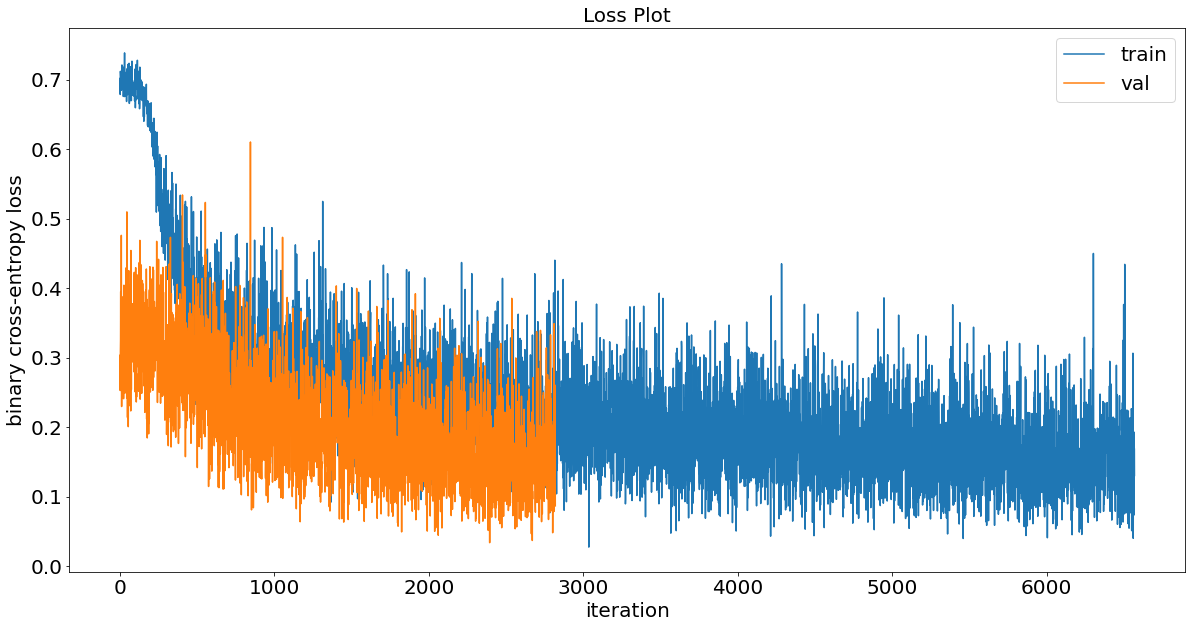

In [20]:
plt.figure(figsize=(20, 10))
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.xlabel("iteration")
plt.ylabel("binary cross-entropy loss")
plt.title("Loss Plot", fontsize=20)
plt.show()

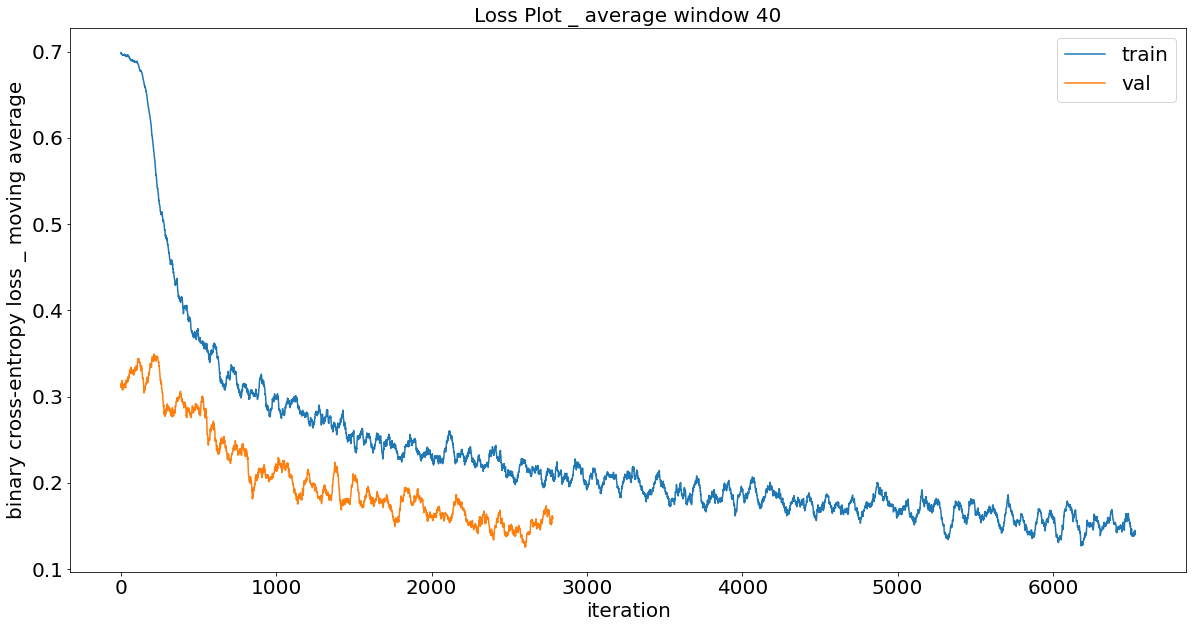

In [21]:
# loss plot with moving average
def rolling_avg(data_list, avg_window):
    cumsum, moving_avg_list = [0], []
    for i, x in enumerate(data_list, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=avg_window:
            moving_avg = (cumsum[i] - cumsum[i-avg_window])/avg_window
            moving_avg_list.append(moving_avg)
    return moving_avg_list

avg_window = 40

plt.figure(figsize=(20, 10))
plt.plot(rolling_avg(train_losses, avg_window), label='train')
plt.plot(rolling_avg(val_losses, avg_window), label='val')
plt.legend()
plt.xlabel("iteration")
plt.ylabel("binary cross-entropy loss _ moving average")
plt.title("Loss Plot _ average window 40", fontsize=20)
plt.show()

## Visualize accuracy & ROC

Epoch 0 | test | loss: 0.0918: 100%|██████████| 157/157 [00:06<00:00, 24.78it/s]


test accuracy = 0.9282


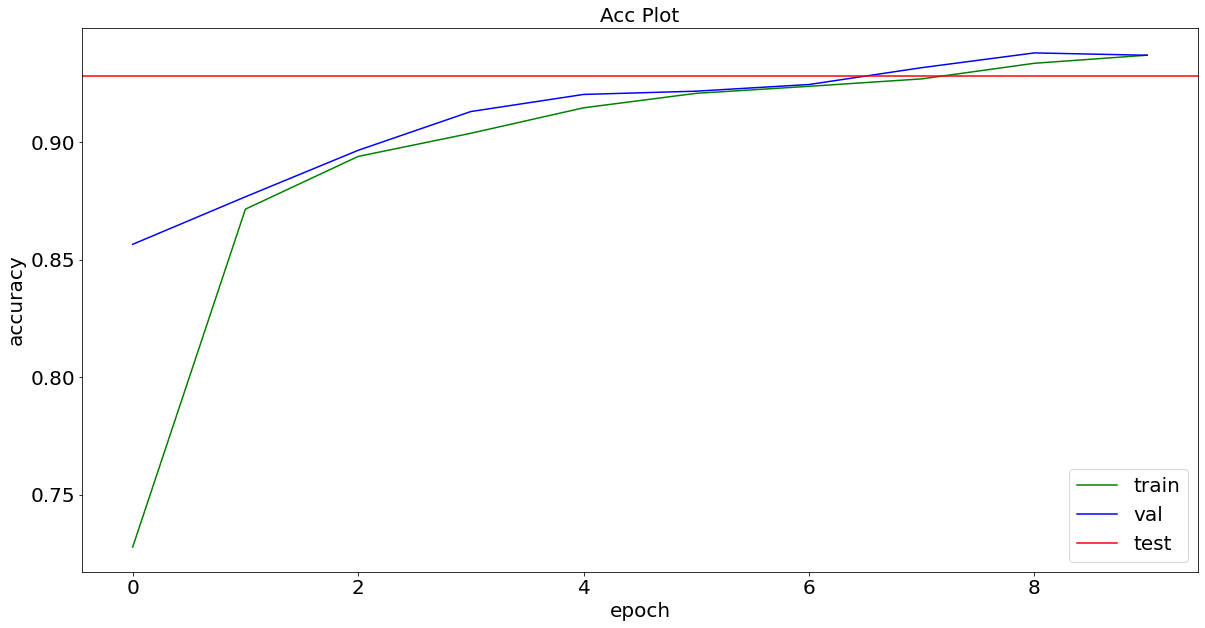

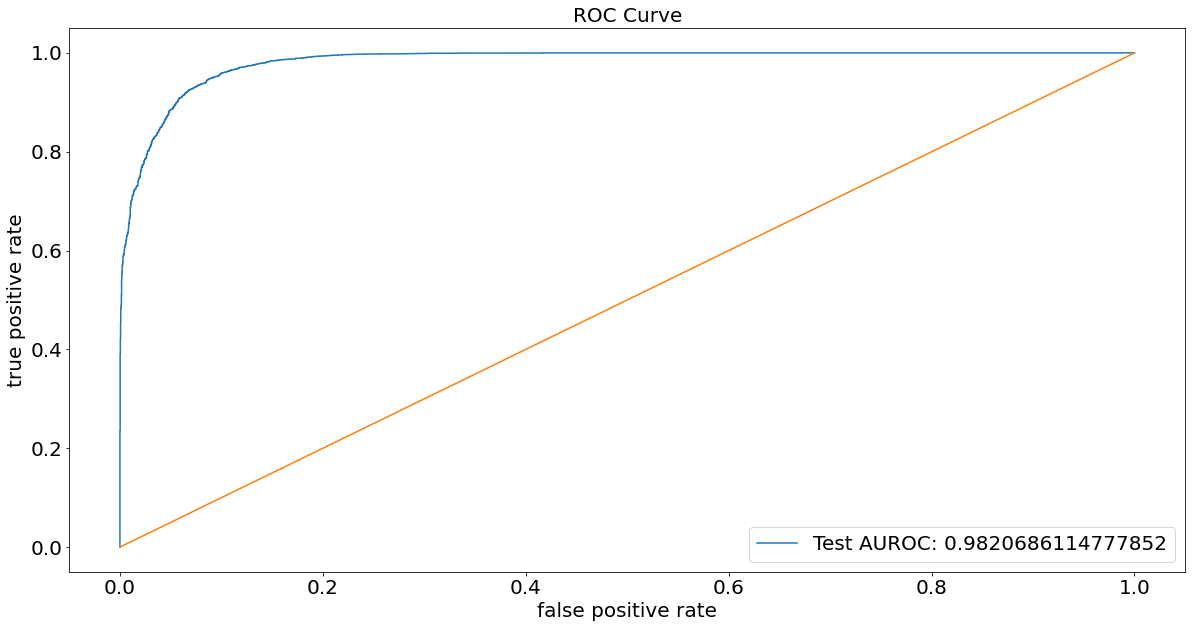

In [22]:
losses, pred, gt = epoch('test')
test_acc = accuracy(gt, pred, threshold=0.5)
print("test accuracy = {}".format(test_acc))

gt = torch.cat(gt).reshape(-1,).detach().cpu()
pred = torch.cat(pred).reshape(-1,).detach().cpu()
fpr, tpr, _ = roc_curve(gt, pred)

plt.figure(figsize=(20, 10))
plt.plot(train_acc, label='train', c='g')
plt.plot(val_acc, label='val', c='b')
plt.axhline(test_acc, label='test', c='r')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Acc Plot", fontsize=20)
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(fpr, tpr, label="Test AUROC: {}".format(roc_auc_score(gt, pred)))
plt.plot(tpr, tpr)
plt.legend()
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve", fontsize=20)
plt.show()

## Visualize example batch from train and val

In [23]:
color = [255, 0, 0]
top, bottom, left, right = [2] * 4

def viz_batch(mode):
    loader = eval("{}_loader".format(mode))
    batch = dict_to_device(next(iter(loader)), device)

    model.network.eval()
    with torch.no_grad():
        preds = model.network(batch)
    
    rows, cols = 4, 4
    plt.figure(figsize=(40, 20))
    for i in range(16):
        img = torchvision.utils.make_grid([batch['img1'][i], batch['img2'][i]]).permute(1, 2, 0).cpu().numpy()
        
        gt = batch['class'][i].item()
        pred = preds['class'][i].item()
        
        if round(pred) != gt:
            img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title("GT: {} | Pred: {:.2f}% match".format(gt, 100*pred), fontsize=36)
        
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


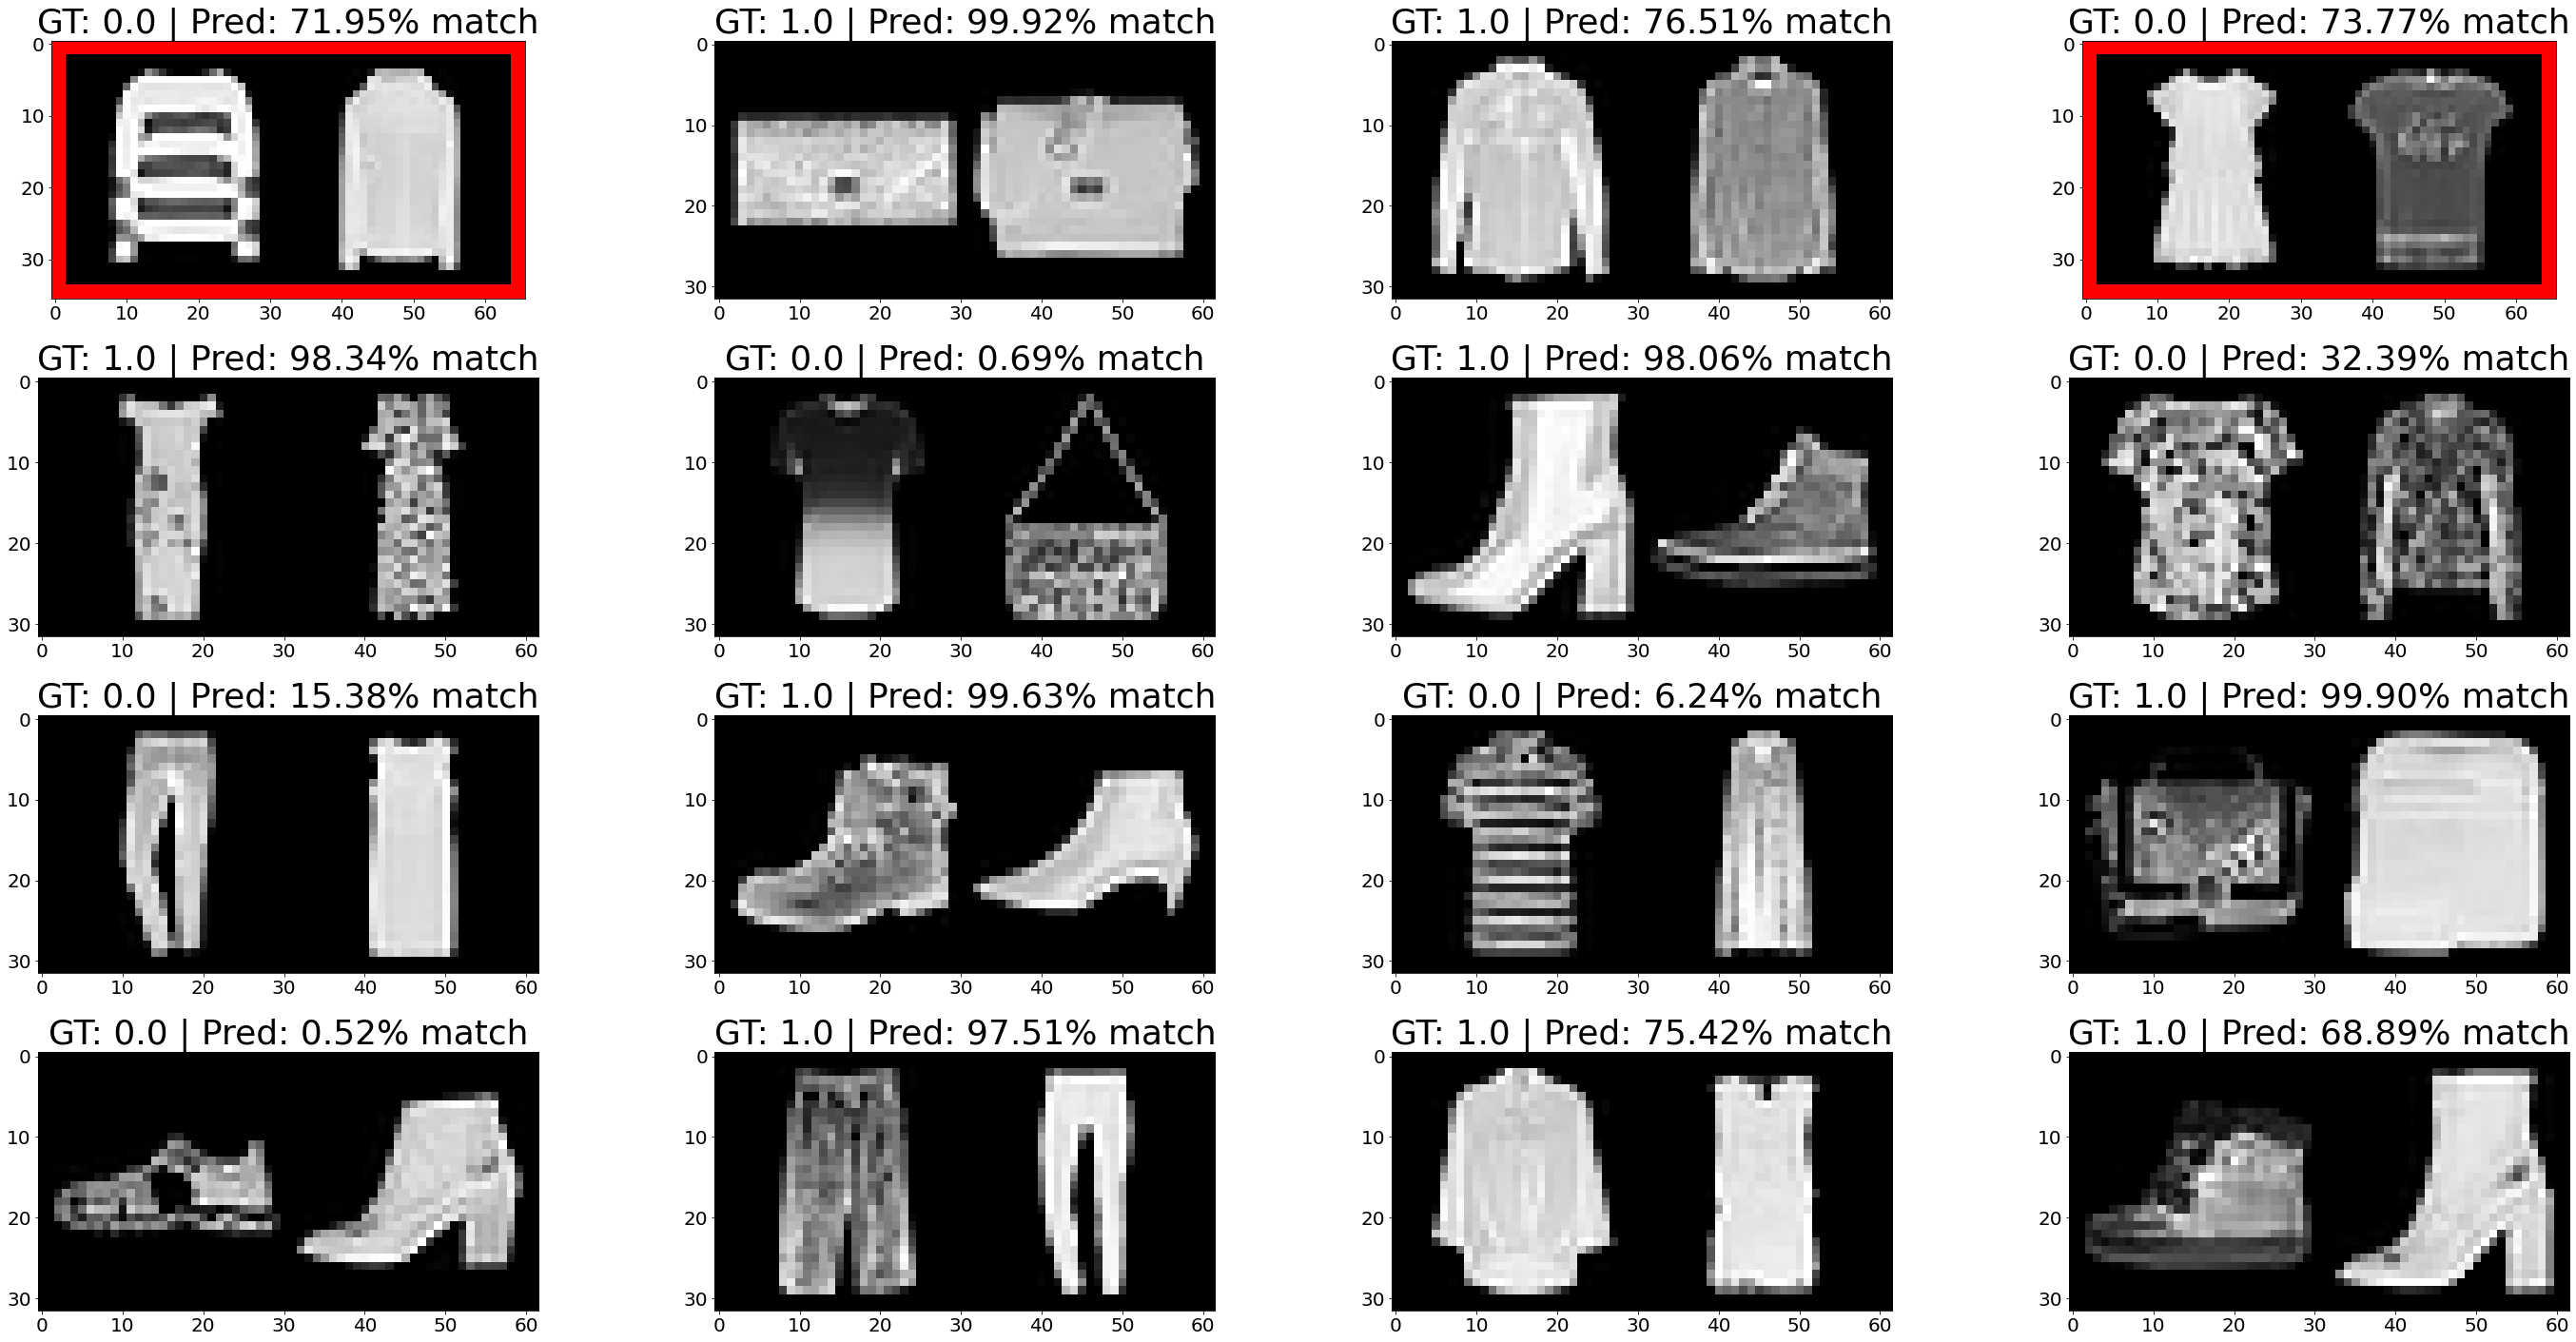

In [24]:
viz_batch("train")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


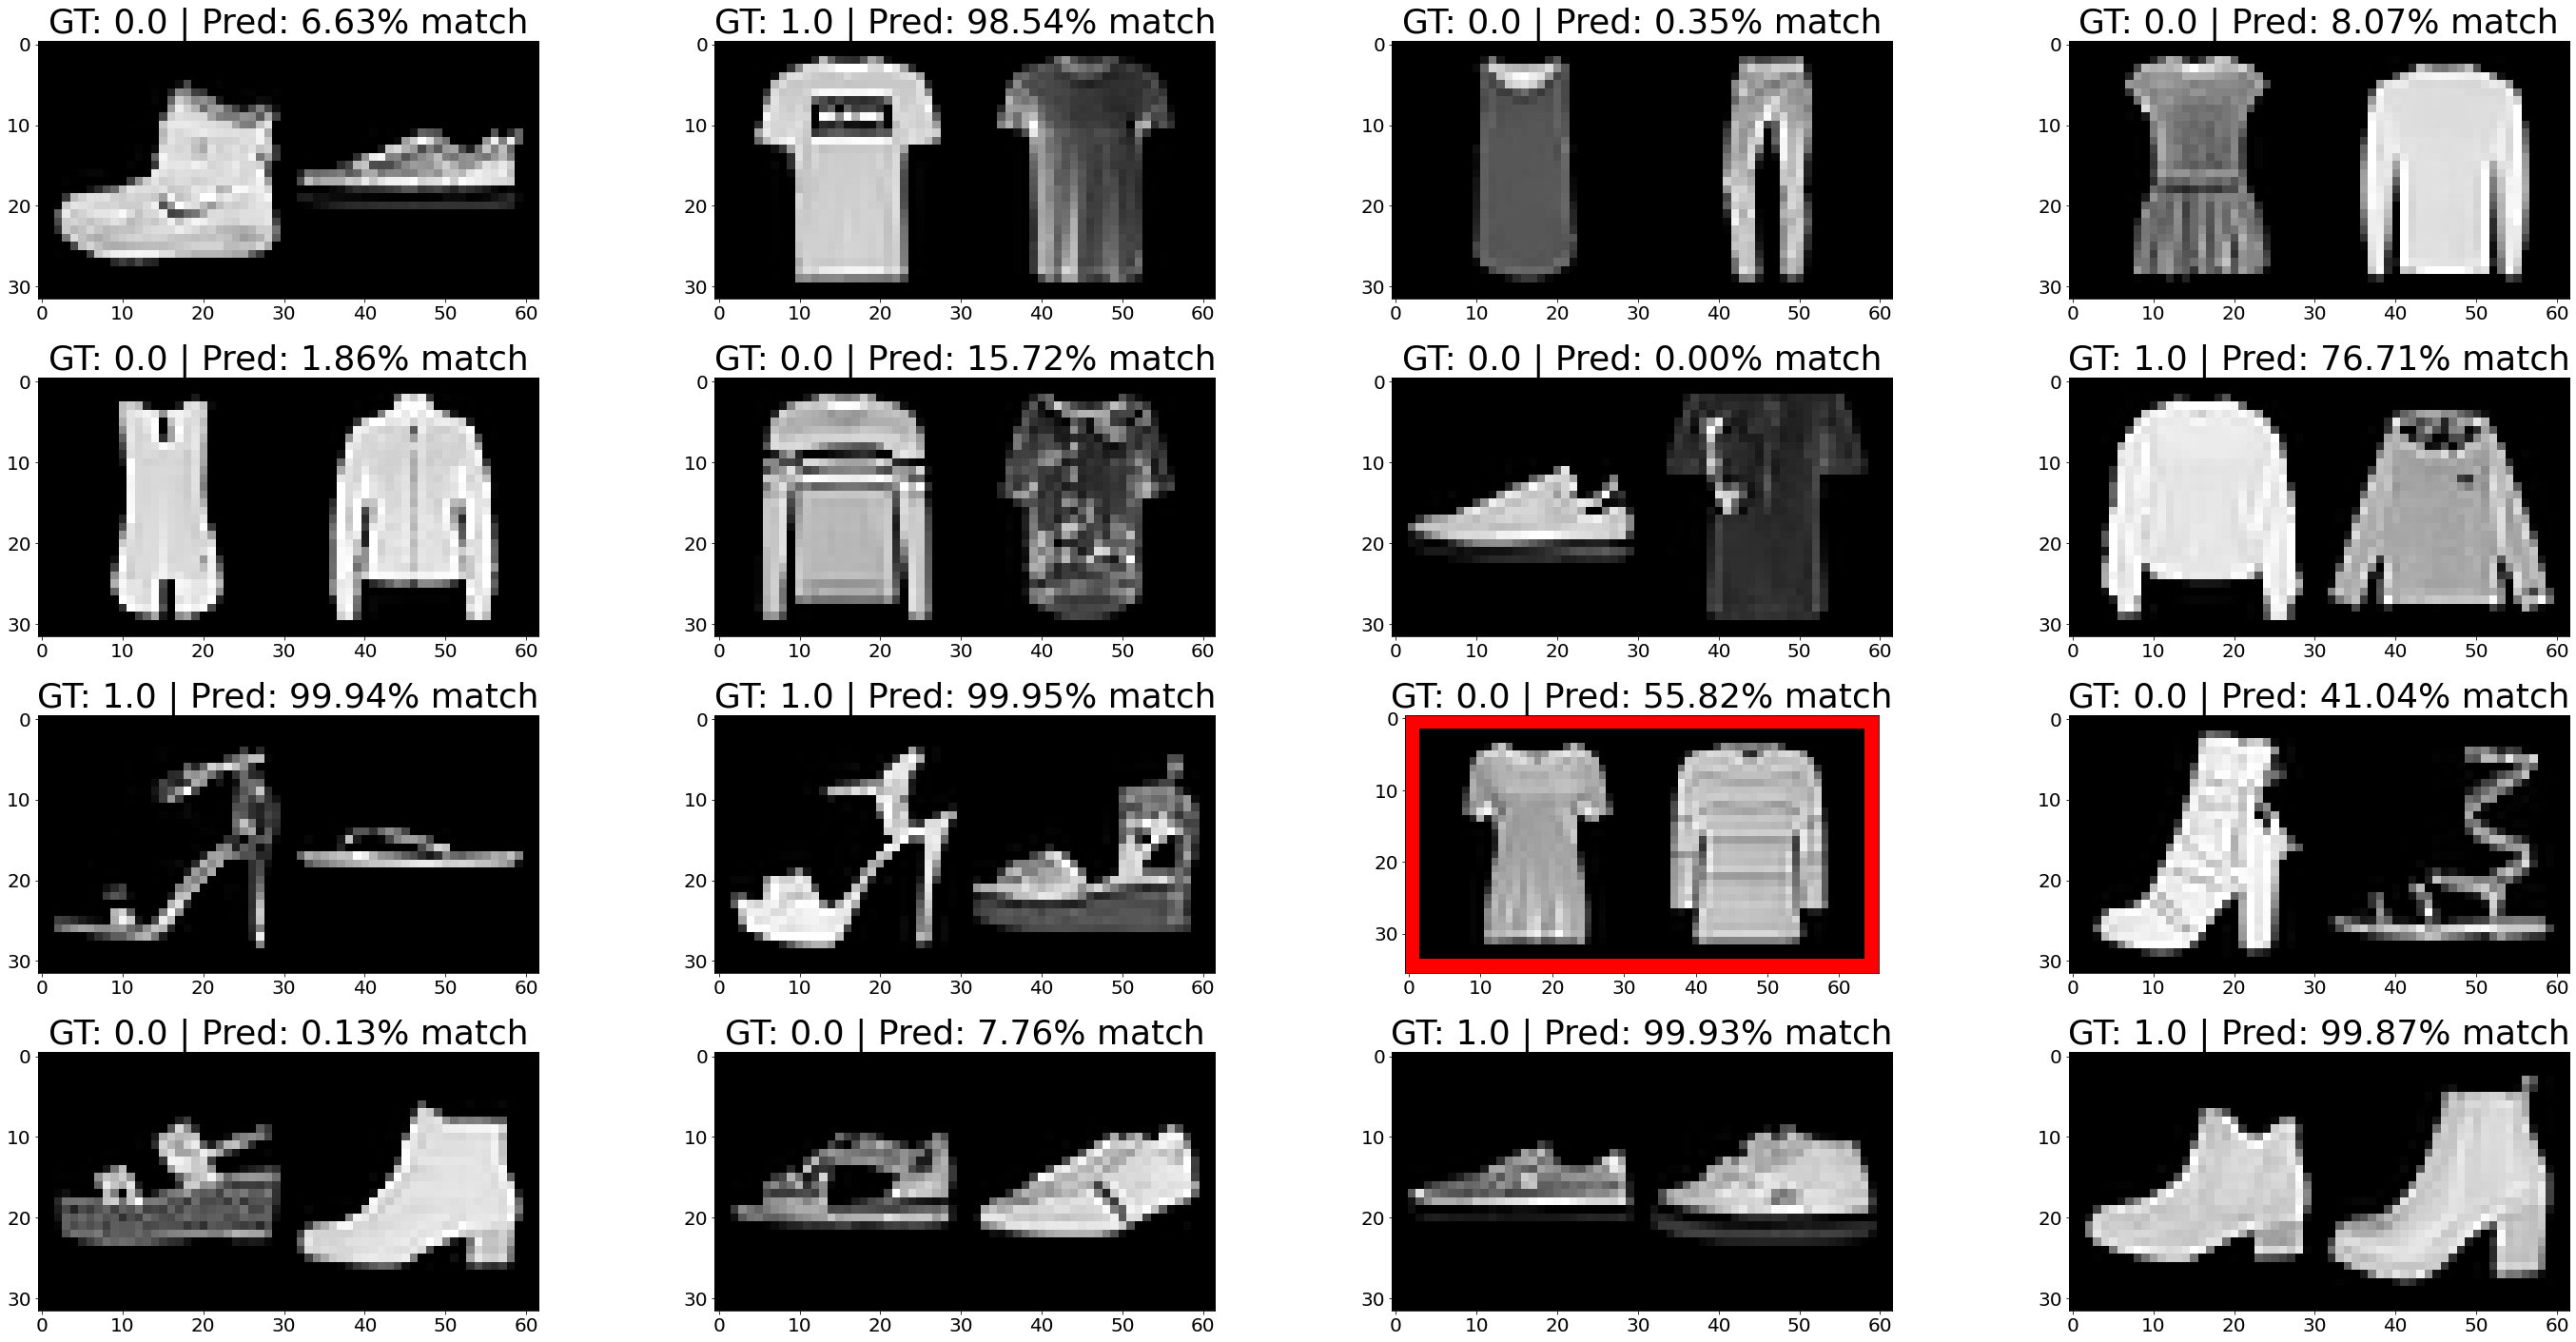

In [25]:
viz_batch("val")